
#計算機概論期末報告


> 計算機概論期末專案：真假新聞判斷 # (部分程式碼參考別人)





    原資料取自於 Kaggle : Fake and real news datasets
    https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
    下面將由雲端導入資料庫

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
#import the modle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras
import nltk
import sklearn
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from matplotlib.font_manager import FontProperties
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD

In [ ]:
!pip install nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

    下面是這次專案的流程圖(flow chart)，由於還沒有找到辦法將 google drive 的圖檔呈現出來，所以就先用程式叫出來。

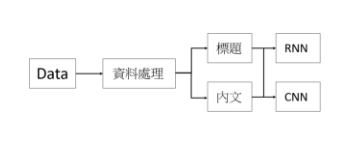

In [ ]:
from scipy import misc
import matplotlib.image as mpimg

img = mpimg.imread('/content/drive/My Drive/Colab Notebooks/資料流程圖.png')
plt.imshow(img)
img.shape
plt.axis('off')
plt.show()

    讀取資料，分成"false(假新聞)"&"true(真新聞)"

In [ ]:
false = pd.read_csv('/content/drive/My Drive/datasets/Fake.csv')
true = pd.read_csv('/content/drive/My Drive/datasets/True.csv')

# 觀察資料


In [ ]:
true.head() 

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true.shape

(21417, 4)

In [ ]:
false.shape

(23481, 4)

    True & Fake 的資料數分別為 21417 筆和 23481 筆，都有 4 種屬性，分別為 : 標題(title) / 內文(text) / 類別(subject) / 日期(date);
    而資料比例約為 48 : 52，是很平均的資料數據集
    再來確認是否有缺失值

In [ ]:
true.isnull().any()

title      False
text       False
subject    False
date       False
dtype: bool

In [ ]:
false.isnull().any()

title      False
text       False
subject    False
date       False
dtype: bool

    先合併資料來觀看資料有哪些種類

In [ ]:
data = pd.concat([true, false])

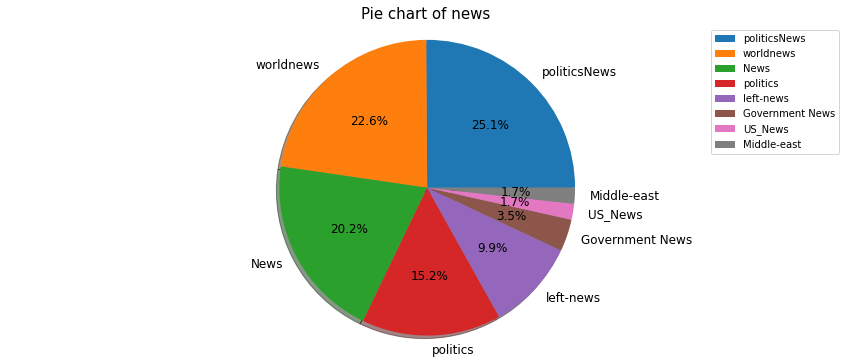

In [ ]:
categories = pd.DataFrame(data['subject'].value_counts())
categories = categories.reset_index()

plt.figure(figsize=(15,6))    # 顯示圖框架大小

labels = categories['index']      # 製作圓餅圖的類別標籤
size = categories['subject']      # 製作圓餅圖的數值來源

plt.pie(size,                           # 數值
        labels = labels,                # 標籤
        autopct = "%1.1f%%",            # 將數值以百分比表示並留到小數點一位
        pctdistance = 0.6,              # 數字距圓心的距離
        textprops = {"fontsize" : 12},  # 文字大小
        shadow=True)                    # 設定陰影

 
plt.axis('equal')                                          # 使圓餅圖比例相等
plt.title("Pie chart of news", {"fontsize" : 15})          # 設定標題及其文字大小
plt.legend(loc = "best")                                   # 設定圖例及其位置為最佳

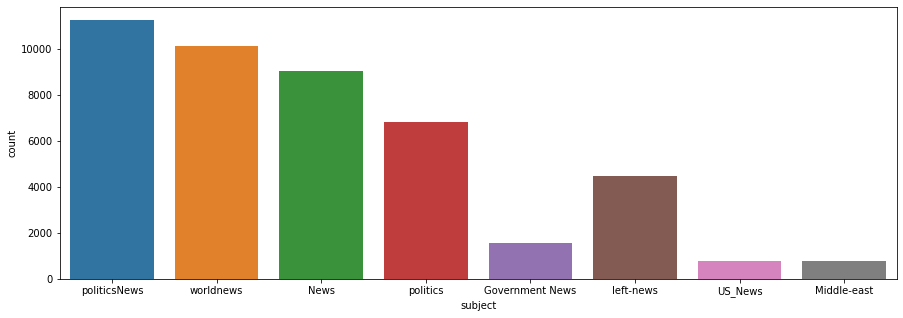

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot("subject", data=data)
plt.show()

    在這個 kaggle 的資料集裡，為數較多的依序是政治、世界新聞、美國本土新聞、政府新聞....還有為數不多的中東新聞。
    其中政治新聞被分成兩個是因為在 true 和 false 的政治新聞有各自的標籤，所以被分開呈現。
    整體而言，最最大量的就是"政治新聞"了。   

# 資料整理
    1. 將 ture & false 各新增一欄位作為標籤，表示該資料的真假。
    2. 合併 true & false 資料集
    3. 刪除 subject & date 屬性，因為較難運用這兩個資訊判斷新聞真假。
    4. 隨機打亂資料集。
    5. 處理標籤。
    6. 資料集分成由"標題"和"內文"所組成的資料集(分別訓練，最後對比成效)。
    7. 兩版本資料集分別建立各自的字典集。
    8. zero-padding
    9. 兩版資料集個別再劃分成"訓練組(train set)"和"驗證組(validation set)"

In [ ]:
# step.1 : 將 ture & false 各新增一欄位作為標籤，表示該資料的真假。

true['label'] = 'true'
false['label'] = 'false'

In [ ]:
# step.2 : 合併 true & false 資料集

data = pd.concat([true, false])

In [ ]:
# step.3
# 先複製一個資料集，刪除複製資料集中的 subject & date 屬性

data_copy = data.copy()
data_copy = data_copy.drop(labels=['date'], axis='columns')

In [ ]:
# step.4 : 隨機打亂資料集。

data_copy = shuffle(data_copy, random_state=41)

In [ ]:
# step.5 處理標籤

label_to_index = {'false':0, 'true':1}
y = data_copy.label.apply(lambda x: label_to_index[x])
y = np.asarray(y).astype('float32')
y = tensorflow.keras.utils.to_categorical(y)

    這裡將原本標籤欄位的"true"和"false"先用字典轉換成 1 和 0，再做 one-hot encoding。
    由於標籤即答案，在這裡就先將資料集內的標籤欄轉換後，直接定義新變數 y 作為後面訓練用。

In [ ]:
# step.6 分成"標題(title)"和"內文(text)"，兩個資料集

data_title = data_copy.drop(labels=['text'], axis='columns')
data_text = data_copy.drop(labels=['title'], axis='columns')

## 文辭分本


### 字典分詞

In [ ]:
# step.7

data_title['title_tokenized'] = data_title.loc[:, 'title'].apply(word_tokenize)
data_text['text_tokenized'] = data_text.loc[:, 'text'].apply(word_tokenize)

# title dictionary
MAX_NUM_WORDS_TITLE = 10000
tokenizer_title = tensorflow.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS_TITLE)

# text dictionary
MAX_NUM_WORDS_TEXT = 20000
tokenizer_text = tensorflow.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS_TEXT)

    這裡使用 Keras 模組內建的 Tokenizer() 來進行文辭分類。 
    將兩個資料集(標題版和內文版)，個別新增一個欄位，放入已經將文辭切分完成的句子。
    而這裡的設定，在"標題版"裡面是限制在 10000 個單字; 在"內文版"裡面是限制在 20000 個單字。

In [ ]:
data_title.head()

,title,subject,label,title_tokenized
20489,LOL! The Woman Who Couldn’t Be Bothered With P...,left-news,false,"[LOL, !, The, Woman, Who, Couldn, ’, t, Be, Bo..."
19511,Trump urges 'strong and swift' U.N. action to ...,worldnews,true,"[Trump, urges, 'strong, and, swift, ', U.N., a..."
18484,JUST IN! SURPRISE GUEST Shows Up At Nationals ...,left-news,false,"[JUST, IN, !, SURPRISE, GUEST, Shows, Up, At, ..."
6714,Trump Has Meltdown Over Kasich And Cruz Joini...,News,false,"[Trump, Has, Meltdown, Over, Kasich, And, Cruz..."
12090,MUST WATCH! New VIDEO Emerges Of Hillary Leavi...,politics,false,"[MUST, WATCH, !, New, VIDEO, Emerges, Of, Hill..."


In [ ]:
# title
corpus_title = data_title.title_tokenized
tokenizer_title.fit_on_texts(corpus_title)
corpus_title_num = tokenizer_title.texts_to_sequences(corpus_title)

# text
corpus_text = data_text.text_tokenized
tokenizer_text.fit_on_texts(corpus_text)
corpus_text_num = tokenizer_text.texts_to_sequences(corpus_text)

    取出剛剛新增欄位 title(text)_tokenized 經過 fit_on_texts() 方法建立字典;
    再經過 texts_to_sequences() 轉換成數字序列

In [ ]:
corpus_title_num[1]

[2, 278, 6610, 22, 5361, 29, 153, 582, 1, 295, 479, 272]

    上述就是原先第一則標題經由轉換後成的數字序列

### zero-padding

In [ ]:
# step.8
# 先觀察全部 title (text) 最多的字數

max_seq_len_title = max([len(seq) for seq in corpus_title_num])
max_seq_len_text = max([len(seq) for seq in corpus_text_num])

print(f'title 最多字數 : {max_seq_len_title} / text 最多字數 : {max_seq_len_text}')

title 最多字數 : 51 / text 最多字數 : 8660


In [ ]:
# text 的平均字數

mean_seq_len_text = np.mean([len(seq) for seq in corpus_text_num])
mean_seq_len_text

438.68555392222373

    由於內文版的文字數最多有8660個字，這裡先算看看平均內文長度再決定取多少字來做 zero-padding。

In [ ]:
MAX_SEQUENCE_LEN_TITLE = 16 # !! 下面解釋
MAX_SEQUENCE_LEN_TEXT = 361

corpus_title_num = tensorflow.keras.preprocessing.sequence.pad_sequences(corpus_title_num, maxlen=MAX_SEQUENCE_LEN_TITLE)
corpus_text_num = tensorflow.keras.preprocessing.sequence.pad_sequences(corpus_text_num, maxlen=MAX_SEQUENCE_LEN_TEXT)

    最後標題版取25個字為限; 內文版取400個字為限。(原模型)
    這裡取的都是平方數是為了後面訓練 CNN 時，可以將其變成一個方陣來訓練。

    !! 當初在訓練資料集的時候，用的是資料集本身的平均字數，但在訓練真實資料時，準確率卻很差。
       嘗試改善準確率所以將模型的字數設定成真實資料集的平均字數 16 和 361。
       雖然在真實應用時無法進行這種改變，但還是想確認是否能經由改變取樣字數來增進準確度。

## 分開訓練組和驗證組

In [ ]:
# step.9

VALIDATION_RATIO = 0.2
RANDOM_STATE = 9527

title_x_train, title_x_val, y_train, y_val = train_test_split(corpus_title_num, y, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)
text_x_train, text_x_val, y_train, y_val = train_test_split(corpus_text_num, y, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

In [ ]:
print("Training Set")
print('-'*20)
print(f"title_x_train: {title_x_train.shape}")
print(f"text_x_train: {text_x_train.shape}")
print(f"y_train: {y_train.shape}")
print('-'*20)
print(f"title_x_val: {title_x_val.shape}")
print(f"text_x_val: {text_x_val.shape}")
print(f"y_val: {y_val.shape}")
print('-'*20)

Training Set
--------------------
title_x_train: (35918, 16)
text_x_train: (35918, 361)
y_train: (35918, 2)
--------------------
title_x_val: (8980, 16)
text_x_val: (8980, 361)
y_val: (8980, 2)
--------------------


    這裡將資料集分成 80% 的訓練組和 20% 的驗證組，各有 35918 / 8980 筆資料。
    標題版的每筆資料裡面有16個Tokens / 內文版的每筆資料裡面有361個Tokens
    分類結果有 2 種(True & False)

# 建立模型

## RNN

#### Title Edition

In [ ]:
RNN_title = Sequential()
RNN_title.add(Embedding(10000, 256))
RNN_title.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
RNN_title.add(Dense(32, activation='relu'))
RNN_title.add(Dense(2, activation='relu'))
RNN_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
RNN_title.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,644,322
Trainable params: 2,644,322
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RNN_title.fit(title_x_train, y_train, batch_size=30, epochs=2, validation_data=(title_x_val, y_val))

Epoch 1/2
1198/1198 [==============================] - 145s 121ms/step - loss: 0.1628 - accuracy: 0.9604 - val_loss: 0.0770 - val_accuracy: 0.9790
Epoch 2/2
1198/1198 [==============================] - 146s 121ms/step - loss: 0.0498 - accuracy: 0.9895 - val_loss: 0.0916 - val_accuracy: 0.9802


#### Text Edition

In [ ]:
RNN_text = Sequential()
RNN_text.add(Embedding(20000, 256))
RNN_text.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
RNN_text.add(Dense(32, activation='relu'))
RNN_text.add(Dense(2, activation='relu'))
RNN_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
RNN_text.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 5,204,322
Trainable params: 5,204,322
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RNN_text.fit(text_x_train, y_train, batch_size=30, epochs=2, validation_data=(text_x_val, y_val))

Epoch 1/2
1198/1198 [==============================] - 2303s 2s/step - loss: 0.2171 - accuracy: 0.9612 - val_loss: 0.0942 - val_accuracy: 0.9785
Epoch 2/2
1198/1198 [==============================] - 2319s 2s/step - loss: 2.1821 - accuracy: 0.7571 - val_loss: 2.0867 - val_accuracy: 0.7688


## CNN

#### Title Edition

In [ ]:
title_x_train_cnn = title_x_train.reshape(len(title_x_train), 4, 4, 1)
title_x_val_cnn = title_x_val.reshape(len(title_x_val), 4, 4, 1)

title_x_train_cnn = title_x_train_cnn / MAX_NUM_WORDS_TITLE
title_x_val_cnn = title_x_val_cnn / MAX_NUM_WORDS_TITLE

CNN_title = Sequential()
CNN_title.add(Conv2D(16, (3,3), padding='same', input_shape=(4, 4, 1), activation='relu'))
CNN_title.add(MaxPooling2D(pool_size=(2,2)))
CNN_title.add(Conv2D(8, (3,3), padding='same', activation='relu'))
CNN_title.add(MaxPooling2D(pool_size=(2,2)))
CNN_title.add(Flatten())
CNN_title.add(Dense(64, activation='relu'))
CNN_title.add(Dense(2, activation='softmax'))
CNN_title.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 16)          160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 8)           1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
CNN_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_title.fit(title_x_train_cnn, y_train, batch_size=30, epochs=10, validation_data=(title_x_val_cnn, y_val))

Epoch 1/10
1198/1198 [==============================] - 5s 5ms/step - loss: 0.4845 - accuracy: 0.7774 - val_loss: 0.4526 - val_accuracy: 0.8027
Epoch 2/10
1198/1198 [==============================] - 5s 4ms/step - loss: 0.4188 - accuracy: 0.8217 - val_loss: 0.4215 - val_accuracy: 0.8163
Epoch 3/10
1198/1198 [==============================] - 5s 4ms/step - loss: 0.4043 - accuracy: 0.8262 - val_loss: 0.4109 - val_accuracy: 0.8220
Epoch 4/10
1198/1198 [==============================] - 5s 5ms/step - loss: 0.3940 - accuracy: 0.8313 - val_loss: 0.4244 - val_accuracy: 0.8203
Epoch 5/10
1198/1198 [==============================] - 5s 5ms/step - loss: 0.3886 - accuracy: 0.8332 - val_loss: 0.3991 - val_accuracy: 0.8266
Epoch 6/10
1198/1198 [==============================] - 5s 4ms/step - loss: 0.3826 - accuracy: 0.8363 - val_loss: 0.4074 - val_accuracy: 0.8170
Epoch 7/10
1198/1198 [==============================] - 5s 5ms/step - loss: 0.3805 - accuracy: 0.8381 - val_loss: 0.3919 - val_accuracy:

#### Text Edition

In [ ]:
text_x_train_cnn = text_x_train.reshape(len(text_x_train), 19, 19, 1)
text_x_val_cnn = text_x_val.reshape(len(text_x_val), 19, 19, 1)

text_x_train_cnn = text_x_train_cnn / MAX_NUM_WORDS_TEXT
text_x_val_cnn = text_x_val_cnn / MAX_NUM_WORDS_TEXT

CNN_text = Sequential()
CNN_text.add(Conv2D(32, (3,3), padding='same', input_shape=(19, 19, 1), activation='relu'))
CNN_text.add(MaxPooling2D(pool_size=(2,2)))
CNN_text.add(Conv2D(8, (3,3), padding='same', activation='relu'))
CNN_text.add(MaxPooling2D(pool_size=(2,2)))
CNN_text.add(Flatten())
CNN_text.add(Dense(64, activation='relu'))
CNN_text.add(Dense(2, activation='softmax'))
CNN_text.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19, 19, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 8)           2312      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [ ]:
CNN_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_text.fit(text_x_train_cnn, y_train, batch_size=30, epochs=10, validation_data=(text_x_val_cnn, y_val))

Epoch 1/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6617 - accuracy: 0.5825 - val_loss: 0.6478 - val_accuracy: 0.6023
Epoch 2/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6379 - accuracy: 0.6033 - val_loss: 0.6419 - val_accuracy: 0.6053
Epoch 3/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6319 - accuracy: 0.6093 - val_loss: 0.6340 - val_accuracy: 0.6066
Epoch 4/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6269 - accuracy: 0.6209 - val_loss: 0.6327 - val_accuracy: 0.6151
Epoch 5/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6213 - accuracy: 0.6233 - val_loss: 0.6246 - val_accuracy: 0.6311
Epoch 6/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6165 - accuracy: 0.6325 - val_loss: 0.6197 - val_accuracy: 0.6294
Epoch 7/10
1198/1198 [==============================] - 6s 5ms/step - loss: 0.6125 - accuracy: 0.6386 - val_loss: 0.6160 - val_accuracy:

## 模型成果比較
    為比較 標題版 vs. 內文版 / RNN vs. CNN 所以模型設定參數皆為相同(batch_size, epochs)。
    所以準確率不好的模型將不會為了增加準確率而進行修正。

    準確率
                    acc   /  val_acc
      RNN_標題  |  0.9877 /   0.9804
      RNN_內文  |  0.9724 /   0.9531
      CNN_標題  |  0.8475 /   0.8513
      CNN_內文  |  0.6555 /   0.6242

    很明顯 RNN 準確率遠高於 CNN，說明 RNN 架構確實是更有利於學習有關語言和句子的問題。
    而標題和內文的比較可以看出來，標題版的準確率都高過於內文版的準確率，這可能表示說標題相較內文有更能判斷是否為假消息的特性。
    在下面測試真實數據時會有更明顯的差別。

# 測試
    我們將套用先前的各種模型在我們蒐集的新聞集中(為100筆，50為真，50為假)。
    假新聞是 Line 訊息查核平台的新聞，此網站的新聞為"已查核訊息"，也就是假訊息;而真新聞是由公視新聞得來。
    蒐集來的中文資料經過 google translater 翻譯成英文後當作現實資料使用。

In [ ]:
LineNews = pd.read_csv('/content/drive/My Drive/datasets/LineNews.csv')
PTSNews = pd.read_csv('/content/drive/My Drive/datasets/PTSNews.csv')

    定義一個函數來將兩個資料集的資料轉換成能使用 model 的型態。

In [ ]:
def DataScrubbing(true, false): 
    
    true['label'] = 'true'           #設定真假標籤
    false['label'] = 'false'
    data = pd.concat([true, false])  #結合兩個資料集
    data = shuffle(data)             #打亂資料
    
    label_to_index = {'false':0, 'true':1}
    y = data.label.apply(lambda x: label_to_index[x]) #真假標籤轉換成數字
    y = np.array(y) #為了和模型預測出的結果對照，先轉換型態
    
    data_title = data.drop(labels=['text', 'label'], axis='columns') #標題版
    data_text = data.drop(labels=['title', 'label'], axis='columns') #內文版

    data_title['title_tokenized'] = data_title.loc[:, 'title'].apply(word_tokenize) #將句子切割成文字
    data_text['text_tokenized'] = data_text.loc[:, 'text'].apply(word_tokenize)
    
    data_title_num = tokenizer_title.texts_to_sequences(data_title['title_tokenized']) #將切割完的文字轉換成數字
    data_text_num = tokenizer_title.texts_to_sequences(data_text['text_tokenized'])
    
    data_title_num = tensorflow.keras.preprocessing.sequence.pad_sequences(data_title_num, maxlen=16) #每句取的字數(取法在後面說明)
    data_text_num = tensorflow.keras.preprocessing.sequence.pad_sequences(data_text_num, maxlen=361)

    data_title_cnn = data_title_num.reshape(len(data_title_num), 4, 4, 1) / 10000
    data_text_cnn =  data_text_num.reshape(len(data_text_num), 19, 19, 1) / 20000

    return data_title_num, data_text_num, y, data_title_cnn, data_text_cnn # output: 標題版 / 內文版 / 答案 / CNN標題版 / CNN內文版

In [ ]:
RealTitle_RNN, RealText_RNN, Answer, RealTitle_CNN, RealText_CNN = DataScrubbing(PTSNews, LineNews)

    字數取法 : 
        由於還有 CNN 模型，所以這裡取的數字皆為平方數，方便後面使用。
        標題版的平均字數 = 12.15，這裡取 16 個字來做測試。
        標題版的平均字數 = 344.2，這裡取 361 個字來做測試。
    

In [ ]:
RealTitle_num = []
RealText_num = []

for i in range(0, 100): #100筆資料
  RealTitle_num.append(len(RealTitle_RNN[i]))
  RealText_num.append(len(RealText_RNN[i]))

mean_num = [np.mean(RealTitle_num), np.mean(RealText_num)]
mean_num = pd.DataFrame(mean_num, index=('標題版', '內文版'), columns=['平均字數'])

max_num = [max(RealTitle_num), max(RealText_num)]
max_num = pd.DataFrame(max_num, index=('標題版', '內文版'), columns=['最多字數'])

median_num = [np.median(RealTitle_num), np.median(RealText_num)]
median_num = pd.DataFrame(median_num, index=('標題版', '內文版'), columns=['中位數'])

df = mean_num.join(max_num.join(median_num))
df

,平均字數,最多字數,中位數
標題版,16.0,16,16.0
內文版,361.0,361,361.0


#### 各模型測試

In [ ]:
RNN_title_answer = RNN_title.predict_classes(RealTitle_RNN, batch_size=10)
RNN_text_answer = RNN_text.predict_classes(RealText_RNN, batch_size=10)
CNN_title_answer = CNN_title.predict_classes(RealTitle_CNN, batch_size=10)
CNN_text_answer = CNN_text.predict_classes(RealText_CNN, batch_size=10)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
Total_ans = [RNN_title_answer, RNN_text_answer, CNN_title_answer, CNN_text_answer]
Accuracy_ans = Total_ans - Answer

    計算預測結果的準確率，由於模型輸出為 0 和 1，將預測出來的答案減去正確答案，非零的就是預測錯誤的。

In [ ]:
Accuracy = []

for j in range(0, 4):
  error_amount = 0
  for i in range(0, 100):
    if Accuracy_ans[j][i] != 0:
      error_amount += 1
    else:
      continue
  Accuracy.append(error_amount)

Accuracy = pd.DataFrame((100 - np.array(Accuracy)) / 100, columns=['Accuracy'])

    模型準確度

In [ ]:
Accuracy['Models']=['RNN_title', 'RNN_text', 'CNN_title', 'CNN_text']
Accuracy

,Accuracy,Models
0,0.68,RNN_title
1,0.32,RNN_text
2,0.66,CNN_title
3,0.49,CNN_text


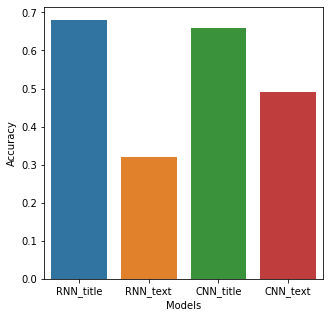

In [ ]:
# 繪製準確率表
plt.figure(figsize=(5,5))
sns.barplot(x='Models',y='Accuracy',data=Accuracy)
plt.show()

    模型實用在真實資料時的表現遠低於預期，最高也只有70%，還有一些比用猜的機率還低，即使更改原本模型的字數設定也準確率沒有相對應的改善。
    很有可能是真實資料本身的問題，以下列出設想可能影響準確率的問題:

      1. 新聞種類 : 
          在資料整理的時候就可以看到原始資料大多數都是"政治新聞"居多，還有一些"本土(美國)新聞"；除了國際新聞可能有類似的內容外，絕大多數的新聞和我們採集的性質
          都不同，更不用說我們新聞還是隨機選取的，沒有一定的分類，可能是時事、政治、地方新聞...，和原資料差異太大，訓練出的模型沒法適應，就不會有太好的精準度。

      2. 標題撰寫 : 
          標題就是能透露出整個內文精華的一段話。在原始資料裡的標題字數平均和我們找的資料平均數差不多，分別為 13.9 和 12.15，差異不大。由於原始資料標題大多數都
          是關於"美國政治"，而英美媒體在撰寫新聞稿時，標題時常需要用縮寫和忽略時態，還有既定架構；而我們的資料是由中文用 google 翻譯直翻英文，缺乏英文文句架構
          也沒有既定形式；若模型在原始資料中找到了一些隱晦的模式類似於英美媒體撰寫的架構的話，在測試我們這邊的資料時，就不會展現出很好的成果。

      3. 資料大小 : 
          我們自己只蒐集 100 筆資料而已，要用這 100 筆來說模型好壞是十分不精準的，沒辦法展示出他面對大量資料時的表現，只能看出一些較淺的問題，像基礎建構時
          使用不同模型的優劣、標題內文對於判斷假新聞的準確度差異。

      4. 內容 :
          原始訓練資料大多數來字路透社、推特...等網站，不論在標題和內文部分，都夾雜著"Reuters"或是"Twitter"字眼，在資料處理時，我們並沒有將其處理掉，而將這些
          字也當作訓練資料一同丟進模型當中訓練，所以訓練出的模型可能學到一些既定的形式，例如:出現"Reuters"的大部分都是真的、出現"Twitter"的大部分都是假的類似
          這樣的潛在特徵。

# 總結

    雖然並沒有訓練出能夠實際應用在生活中的適用模型，但經由模型各自比較和測試真實資料的結果，我們發現從標題來判斷假新聞是比從內文判斷來的準確的。
    這也跟現實相呼應，現在很多新聞的標題都誇張不實，擷取內容的各種"強烈"字眼來作為標題，來吸引讀者的眼睛，所以才會導致有那麼多標題殺人的事件發生。
    在模型方面，我們不認為他訓練的不夠好，而是我們應該蒐集偏英美的新聞資料來進行測試，才能確實了解該模型的缺失，進一步改善模型。
    而蒐集資料，也需要做好各方面的準備，包括:資料分類、各種類別的資料數量應維持適當平衡、取材來源應廣泛採納，以免專用一家新聞媒體的資料而學習到該媒體的一些淺在模式。

感謝收看:)

In [ ]:
# 避免使用到訓練用資料，這裡要取測試資料作為各類別分類的測試集
q_x_train, q_x_val, q_y_train, q_y_val = train_test_split(data_copy, y, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

In [ ]:
def question_answer(name): #資料處理

  name['title_tokenized'] = name.loc[:, 'title'].apply(word_tokenize)
  name_title_num = tokenizer_title.texts_to_sequences(name['title_tokenized'])
  name_title_num = tensorflow.keras.preprocessing.sequence.pad_sequences(name_title_num, maxlen=MAX_SEQUENCE_LEN_TITLE)
  name_title_cnn =  name_title_num.reshape(len(name_title_num), 4, 4, 1) / 20000

  CNN_answer = CNN_title.predict_classes(name_title_cnn, batch_size=10)
  RNN_answer = RNN_title.predict_classes(name_title_num, batch_size=10)
  
  return CNN_answer, RNN_answer

In [ ]:
politicsNews = q_x_val[q_x_val['subject'] == 'politicsNews']
worldnews = q_x_val[q_x_val['subject'] == 'worldnews']
News = q_x_val[q_x_val['subject'] == 'News']
politics = q_x_val[q_x_val['subject'] == 'politics']
left_news = q_x_val[q_x_val['subject'] == 'left-news']
GovernmentNews = q_x_val[q_x_val['subject'] == 'Government News']
US_News = q_x_val[q_x_val['subject'] == 'US_News']
Middle_east = q_x_val[q_x_val['subject'] == 'Middle-east']

In [ ]:
politicsNews_cnn, politicsNews_rnn = question_answer(politicsNews)
worldnews_cnn, worldnews_rnn = question_answer(worldnews)
News_cnn, News_rnn = question_answer(News)
politics_cnn, politics_rnn = question_answer(politics)
left_news_cnn, left_news_rnn = question_answer(left_news)
GovernmentNews_cnn, GovernmentNews_rnn = question_answer(GovernmentNews)
US_News_cnn, US_News_rnn = question_answer(US_News)
Middle_east_cnn, Middle_east_rnn = question_answer(Middle_east)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


    在True資料庫中出來的答案都是"1"，在False資料庫中出來的答案都是"0"。
    模型預測出的結果:
    1. True資料庫分類的總和，和整個資料數目的差距就是預測錯誤的數量。
    2. False資料庫分類的總和，直接就是錯誤的數量。

### RNN
    

In [ ]:
print(sum(politicsNews_rnn), sum(worldnews_rnn), sum(News_rnn), sum(politics_rnn), sum(left_news_rnn), sum(GovernmentNews_rnn),
      sum(US_News_rnn), sum(Middle_east_rnn))

2140 2040 67 16 3 3 5 4


In [ ]:
q_x_val['subject'].value_counts() # 除了前面兩個分類是 True 資料庫蒐集的資料外都是 False 資料庫的資料。 

politicsNews       2208
worldnews          2052
News               1846
politics           1363
left-news           894
Government News     297
Middle-east         167
US_News             153
Name: subject, dtype: int64

In [ ]:
accuracy_rnn = [2140/2208, 2040/2052, 1-(67/1846), 1-(16/1363), 1-(3/894), 1-(3/297), 1-(5/167), 1-(4/153)]

In [ ]:
accuracy_rnn

[0.9692028985507246,
 0.9941520467836257,
 0.9637053087757314,
 0.9882611885546588,
 0.9966442953020134,
 0.98989898989899,
 0.9700598802395209,
 0.9738562091503268]

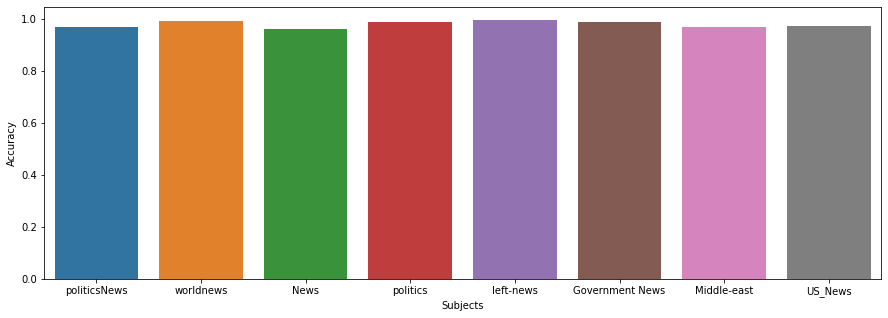

In [ ]:
# RNN
Accuracy = pd.DataFrame((accuracy_rnn), columns=['Accuracy'])
Accuracy['Subjects']=['politicsNews', 'worldnews', 'News', 'politics', 'left-news', 'Government News', 'Middle-east', 'US_News']

plt.figure(figsize=(15,5))
sns.barplot(x='Subjects',y='Accuracy',data=Accuracy)
plt.show()

### CNN

In [ ]:
print(sum(politicsNews_cnn), sum(worldnews_cnn), sum(News_cnn), sum(politics_cnn), sum(left_news_cnn), sum(GovernmentNews_cnn),
      sum(US_News_cnn), sum(Middle_east_cnn))

1972 1798 506 186 107 56 83 90


In [ ]:
accuracy_cnn = [1972/2208, 1798/2052, 1-(506/1846), 1-(186/1363), 1-(107/894), 1-(56/297), 1-(83/167), 1-(90/153)]

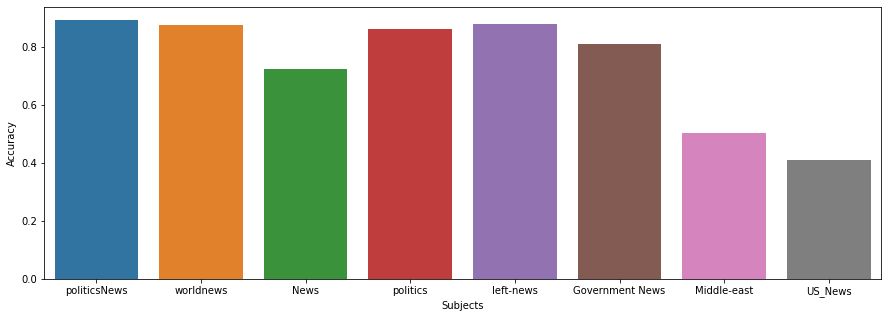

In [ ]:
# CNN
Accuracy = pd.DataFrame((accuracy_cnn), columns=['Accuracy'])
Accuracy['Subjects']=['politicsNews', 'worldnews', 'News', 'politics', 'left-news', 'Government News', 'Middle-east', 'US_News']

plt.figure(figsize=(15,5))
sns.barplot(x='Subjects',y='Accuracy',data=Accuracy)
plt.show()

## 問題 : 解釋模型在各種類別主題上的分辨率
    由於這些資料都是資料庫中本身的，與訓練資料一定有相似的模式。
    在RNN模型上的表現是很好的，各分類的準確率都很高，沒有特別明顯的差距。
    而在CNN模型上，平均準確率較低，在特定新聞的分辨率是很差的，我們認為可能原因可能是:
      1.模型訓練不足 2.資料量太少(Middle-east / US_News)。
    從CNN模型的預測結果可以看出來，politicsNews / politics / left-news / Government News...等政治方面的準確度是相對高的，相對資料量也大，但這也可能
    讓模型學習到的東西偏向了這個方面，導致其他方面 Middle-east / US_News 這些資料量小的分類效果就不是很優秀。
    結果明顯可以看出對於語言的理解，RNN的模型架構是比CNN來的適合許多。
